# Identifying the relationship between the Fair Market Rates and Consumer Price Index of a Metro area

In [1]:
import fetchData
import transformData
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Data Preparation

In [2]:
API_file = 'API_Config.ini'
BLS_area_codes = 'Data/BLS/cu.area.txt'
analysis_start_year = 2014
analysis_end_year = 2024
FMR_implementation_month = 10

### Loading the list of metro areas whose CPI data is present in the Bureau of Labour Statistics database

In [3]:
#fetching series id's for every metro area available in the Bureau of Labour Statistic's database
series_id = fetchData.get_bls_series_id(metro_code_file=BLS_area_codes)
series_id.head()

,area_code,area_name,area_state
1,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH
2,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA
3,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD
5,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI
6,CUURS23BSA0,Detroit-Warren-Dearborn,MI


In [4]:
series_id.isna().sum()

area_code     0
area_name     0
area_state    0
dtype: int64

The dataset has no missing values

#### Cleaning the CPI Data

In [5]:
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',      'Hawaii',      'Alaska']
Length: 18, dtype: string

On further inspection, there are some rows for which the state names [Hawaii and Alaska] are not abbreviated. This can later cause an issue while merging this dataset with the HUD dataset.

In [6]:
series_id.loc[series_id['area_state'] == 'Hawaii','area_state'] = 'HI'
series_id.loc[series_id['area_state'] == 'Alaska','area_state'] = 'AK'
series_id['area_state'].unique()

<StringArray>
[      'MA-NH',    'NY-NJ-PA', 'PA-NJ-DE-MD',    'IL-IN-WI',          'MI',
       'MN-WI',       'MO-IL', 'DC-VA-MD-WV',          'FL',          'GA',
          'MD',          'TX',          'AZ',          'CO',          'CA',
          'WA',          'HI',          'AK']
Length: 18, dtype: string

After processing, the dataframe has no missing / incorrect values.

### Loading the list of metro areas whose FMR data is available in the HUD database

In [7]:
hud_metro_data = fetchData.get_metro_codes_hud(api_config=API_file)
hud_metro_data.head()

,cbsa_code,area_name,area_state
0,METRO10180M10180,Abilene,TX
1,METRO29180N22001,Acadia Parish,LA
2,METRO10380M10380,Aguadilla-Isabela,PR
3,METRO10420M10420,Akron,OH
4,METRO10500M10500,Albany,GA


In [8]:
hud_metro_data.isna().sum()

cbsa_code     0
area_name     0
area_state    0
dtype: int64

This dataset has no missing values.

#### Cleaning the FMR data

In [9]:
hud_metro_data['area_state'].unique()

<StringArray>
[          'TX',           'LA',           'PR',           'OH',
           'GA',           'OR',           'NY',           'NM',
           'KY',           'PA',           'IA',           'AK',
           'IN',           'SC',           'MI',           'AL',
           'WI',           'NC',           'NJ',        'GA-SC',
           'FL',           'CA',           'MD',           'ME',
           'MA',           'MO',           'WA',           'MS',
           'MT',           'ND',           'VA',           'IL',
           'ID',           'WV',        'MA-NH',           'CO',
           'UT',           'CT',           'VT',           'TN',
        'MO-IL',           'NV',           'WY',        'NC-SC',
        'TN-GA',     'OH-KY-IN',        'TN-KY',        'GA-AL',
           'OK',        'MD-WV',           'SD',        'IA-IL',
           'DE',        'MN-WI',        'IN-KY',        'ND-MN',
           'AR',           'MN',           'AZ',        'AR-OK',
           

On further inspection, there is a row for which the state name [TX-Texarkana] is not correct. This can later cause an issue while merging this dataset with the BLS dataset.

In [10]:
hud_metro_data.loc[hud_metro_data['area_state'] == 'TX-Texarkana', 'area_state'] = 'TX'

After processing, the dataframe has no missing / incorrect values.

### Merging the two datasets to get the metro areas for which both the CPI and FMR data is available.

In [11]:
merge_data = pd.merge(series_id, hud_metro_data, on='area_name', how='left', suffixes=('_BLS', '_HUD'))
merge_data.isna().sum()

area_code          0
area_name          0
area_state_BLS     0
cbsa_code         12
area_state_HUD    12
dtype: int64

There are 12 rows from the BLS dataset that have no corresponding metro area in the HUD dataset. Ideally that should not be the case, HUD's database is quite extensive.

In [12]:
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,<NA>,<NA>
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,<NA>,<NA>
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,<NA>,<NA>
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,<NA>,<NA>
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,<NA>,<NA>
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,<NA>,<NA>
12,CUURS37ASA0,Dallas-Fort Worth-Arlington,TX,<NA>,<NA>
16,CUURS49ASA0,Los Angeles-Long Beach-Anaheim,CA,<NA>,<NA>
17,CUURS49BSA0,San Francisco-Oakland-Hayward,CA,<NA>,<NA>
19,CUURS49DSA0,Seattle-Tacoma-Bellevue,WA,<NA>,<NA>


In [13]:
hud_metro_data[hud_metro_data['area_name'].str.contains('Boston')]

,cbsa_code,area_name,area_state
61,METRO14460MM1120,Boston-Cambridge-Quincy,MA-NH


On further investigation, it is observed that the issue is arising due to some slight difference in the names. In this case, either the data from HUD or BLS is not correctly named. The names should not be different as they both are based on 'cbsa' codes. To resolve this, we can try to find the best possible match and proceed accordingly. If no match is found, then that row will be dropped.

In [14]:
unmatched_indices = merge_data[merge_data['cbsa_code'].isna()].index
unmatched_areas_metro = list(merge_data['area_name'][merge_data['cbsa_code'].isna()].apply(lambda x: x.split('-')[0]))
unmatched_dict = dict(zip(unmatched_indices, unmatched_areas_metro))
for i in unmatched_indices:
    hud_area = hud_metro_data[hud_metro_data['area_name'].str.contains(unmatched_dict[i])]
    if len(hud_area) > 1:
        hud_area = hud_area[hud_area['area_state'] == merge_data['area_state_BLS'].loc[i]]
    if len(hud_area) == 1:
        merge_data.loc[i, 'cbsa_code'] = hud_area['cbsa_code'][hud_area['area_name'].str.contains(unmatched_dict[i])].values
merge_data[merge_data['cbsa_code'].isna()]

,area_code,area_name,area_state_BLS,cbsa_code,area_state_HUD
22,CUURS49GSA0,Urban,AK,<NA>,<NA>


In [15]:
merge_data = merge_data.dropna(subset=['cbsa_code']).drop(columns=['area_state_HUD']).rename(columns={'area_state_BLS': 'area_state'})

One row (Urban Alaska) is dropped as there is no corresponding metro area in the HUD dataset.

### Selecting a metro area for analysis

In [16]:
print('following is the list of available metro_areas:')
merge_data.head(100)

following is the list of available metro_areas:


,area_code,area_name,area_state,cbsa_code
0,CUURS11ASA0,Boston-Cambridge-Newton,MA-NH,METRO14460MM1120
1,CUURS12ASA0,New York-Newark-Jersey City,NY-NJ-PA,METRO35620MM5600
2,CUURS12BSA0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,METRO37980M37980
3,CUURS23ASA0,Chicago-Naperville-Elgin,IL-IN-WI,METRO16980M16980
4,CUURS23BSA0,Detroit-Warren-Dearborn,MI,METRO19820M19820
5,CUURS24ASA0,Minneapolis-St.Paul-Bloomington,MN-WI,METRO33460M33460
6,CUURS24BSA0,St. Louis,MO-IL,METRO41180M41180
7,CUURS35ASA0,Washington-Arlington-Alexandria,DC-VA-MD-WV,METRO47900M47900
8,CUURS35BSA0,Miami-Fort Lauderdale-West Palm Beach,FL,METRO33100MM5000
9,CUURS35CSA0,Atlanta-Sandy Springs-Roswell,GA,METRO12060M12060


In [17]:
index = fetchData.select_area(merge_data)

Tampa-St. Petersburg-Clearwater has been selected


### Loading State data for the selected metro area

In [18]:
state_code = merge_data['area_state'].iloc[int(index)].split('-')[0]
state_code

'FL'

In [19]:
state_data = fetchData.fetch_state_fmr_data(api_config=API_file, start_year=analysis_start_year, end_year=analysis_end_year, state_code=state_code, implementation_month=FMR_implementation_month)
state_data.head()

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO27260N12003,477.0,645.0,752.0,951.0,1266.0,2017-10-01
1,METRO15980M15980,687.0,741.0,920.0,1194.0,1331.0,2017-10-01
2,METRO18880M18880,754.0,810.0,961.0,1382.0,1680.0,2017-10-01
3,METRO19660M19660,608.0,764.0,959.0,1298.0,1454.0,2017-10-01
4,METRO33100MM2680,829.0,1023.0,1307.0,1883.0,2303.0,2017-10-01


### Loading CPI data for the selected metro area

In [20]:
cpi_id = merge_data['area_code'].iloc[int(index)]
cpi_id

'CUURS35DSA0'

In [21]:
cpi_data = fetchData.fetch_metro_cpi_bls(api_config=API_file, area_code=cpi_id, start_year=analysis_start_year, end_year=analysis_end_year)
cpi_data.head()

Month,01,03,05,07,09,11
year,,,,,,
2017,<NA>,<NA>,<NA>,<NA>,<NA>,220.102005
2018,221.794006,223.156998,224.026993,224.608002,225.873993,225.246994
2019,222.774002,226.927002,229.018005,229.334,229.218994,229.740005
2020,231.257996,231.619003,231.031998,233.447006,236.804001,236.988998
2021,239.134995,242.910004,245.419006,248.811005,251.220993,255.850998


### Loading FMR data for the selected metro area

In [22]:
cbsa_code = merge_data['cbsa_code'].iloc[int(index)]
cbsa_code

'METRO45300M45300'

In [23]:
cbsa_data = state_data[state_data['code'] == cbsa_code].reset_index(drop=True)

In [24]:
cbsa_data

,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,year
0,METRO45300M45300,714.0,815.0,1014.0,1341.0,1609.0,2017-10-01
1,METRO45300M45300,765.0,842.0,1045.0,1373.0,1656.0,2018-10-01
2,METRO45300M45300,860.0,916.0,1133.0,1485.0,1794.0,2019-10-01
3,METRO45300M45300,935.0,981.0,1206.0,1575.0,1925.0,2020-10-01
4,METRO45300M45300,989.0,1040.0,1271.0,1651.0,2028.0,2021-10-01
5,METRO45300M45300,1044.0,1110.0,1347.0,1732.0,2133.0,2022-10-01
6,METRO45300M45300,1291.0,1381.0,1659.0,2123.0,2603.0,2023-10-01
7,METRO45300M45300,1449.0,1562.0,1851.0,2367.0,2888.0,2024-10-01


## 

## Identifying Lag in CPI and FMR

In [25]:
cpi_data_transformed = transformData.transform_cpi_data(cpi_data)
cpi_data_transformed.tail()

,CPI
Date,
2023-03-01,288.319
2023-05-01,293.269012
2023-07-01,292.973999
2023-09-01,296.145996
2023-11-01,295.028992


In [26]:
combined_data= transformData.smooth_and_merge(fmr=cbsa_data, cpi=cpi_data_transformed, start_month=FMR_implementation_month)

In [27]:
combined_pct_chg = (combined_data-combined_data.shift(1)) / combined_data.shift(1)
combined_pct_chg

,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,CPI
2017-10-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-10-01,0.071429,0.033129,0.030572,0.023863,0.029211,0.017138
2019-10-01,0.124183,0.087886,0.084211,0.081573,0.083333,0.023032
2020-10-01,0.087209,0.070961,0.064431,0.060606,0.073021,0.050638
2021-10-01,0.057754,0.060143,0.053897,0.048254,0.053506,0.101396
2022-10-01,0.055612,0.067308,0.059795,0.049061,0.051775,0.076499
2023-10-01,0.23659,0.244144,0.231626,0.225751,0.220347,0.019468


<Axes: >

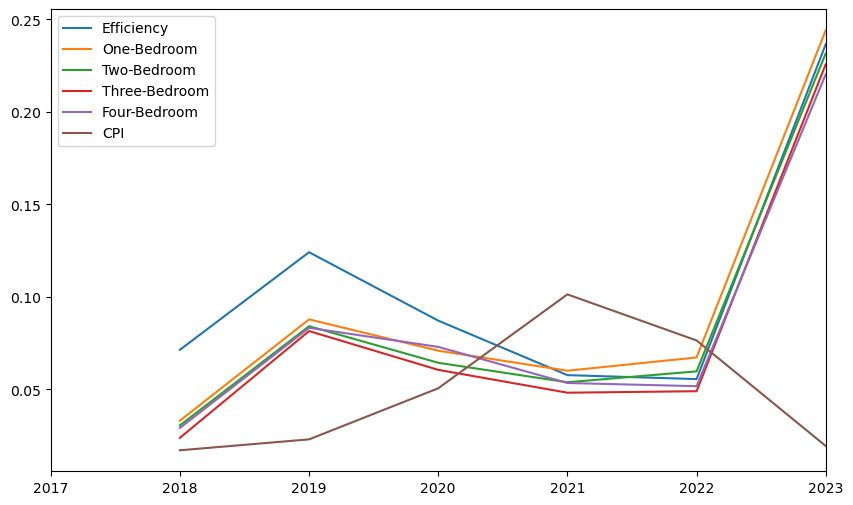

In [28]:
combined_pct_chg.plot(kind='line', figsize=(10, 6))

<Axes: >

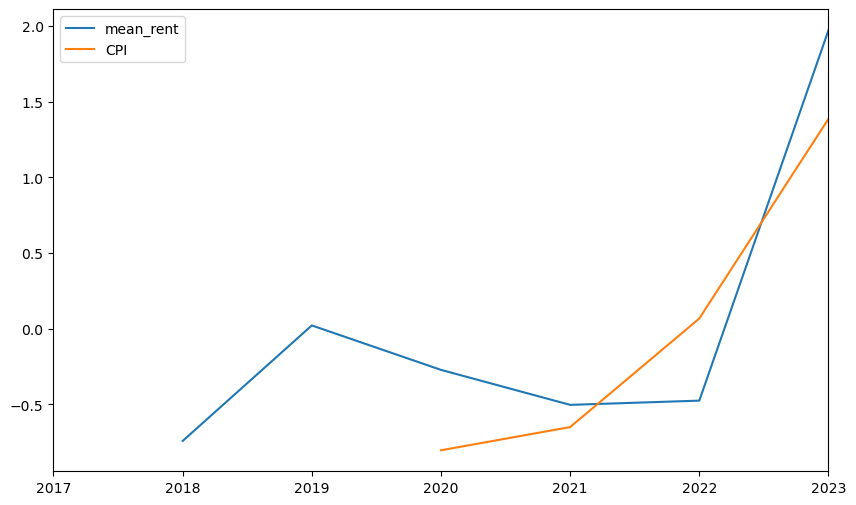

In [35]:
combined_1_yr_shift = combined_pct_chg.copy()
combined_1_yr_shift['CPI'] = combined_1_yr_shift['CPI'].shift(2)
combined_1_yr_shift['mean_rent'] = combined_1_yr_shift[['Efficiency', 'One-Bedroom', 'Two-Bedroom', 'Three-Bedroom', 'Four-Bedroom']].mean(axis=1)
combined_1_yr_shift = (combined_1_yr_shift - combined_1_yr_shift.mean())/combined_1_yr_shift.std()
combined_1_yr_shift[['mean_rent', 'CPI']].plot(kind='line', figsize=(10, 6))